# Image Augmentation
##### Horizontal Flip
##### Zoom
##### shear

In [1]:
import torch
from torch import nn
from pathlib import Path
from torch.nn import functional as F
from torchvision import models
from torchvision.transforms import ToTensor, Normalize, Compose
import cv2
from pathlib import Path

In [2]:
directory = '../data'
device = "cuda"

In [3]:
from TernausNet.unet_models import UNetResNet34,UNet11_bn_dilated,UNet11_bn,UNet11_bn_v2
from lovasz_loss import lovasz_hinge

save_dir = "vgg_dil"
def unet_model(**kwargs):
    model = UNet11_bn_dilated(**kwargs)

    return model

def get_model():
    model = unet_model()
    model.train()
    return model.cuda()

class Loss:
    def __init__(self, dice_weight=1):
        self.nll_loss = nn.BCELoss()
        self.dice_weight = dice_weight

    def __call__(self, outputs, targets):
        loss = self.nll_loss(outputs, targets)
        if self.dice_weight:
            eps = 1e-15
            dice_target = (targets == 1).float()
            dice_output = outputs
            intersection = (dice_output * dice_target).sum()
            union = dice_output.sum() + dice_target.sum() + eps

            dice_loss = 1 - (2 * intersection / union)

        return loss - torch.log(dice_loss)
    
class RobustFocalLoss2d(nn.Module):
    #assume top 10% is outliers
    def __init__(self, gamma=2, size_average=True):
        super(RobustFocalLoss2d, self).__init__()
        self.gamma = gamma
        self.size_average = size_average


    def forward(self, logit, target, class_weight=None, type='softmax'):
        target = target.view(-1, 1).long()


        if type=='sigmoid':
            if class_weight is None:
                class_weight = [1]*2 #[0.5, 0.5]

#             prob   = F.sigmoid(logit)
            prob=logit
            prob   = prob.view(-1, 1)
            prob   = torch.cat((1-prob, prob), 1)
            select = torch.FloatTensor(len(prob), 2).zero_().cuda()
            select.scatter_(1, target, 1.)

        elif  type=='softmax':
            B,C,H,W = logit.size()
            if class_weight is None:
                class_weight =[1]*C #[1/C]*C

            logit   = logit.permute(0, 2, 3, 1).contiguous().view(-1, C)
            prob    = F.softmax(logit,1)
            select  = torch.FloatTensor(len(prob), C).zero_().cuda()
            select.scatter_(1, target, 1.)

        class_weight = torch.FloatTensor(class_weight).cuda().view(-1,1)
        class_weight = torch.gather(class_weight, 0, target)

        prob  = (prob*select).sum(1).view(-1,1)
        prob  = torch.clamp(prob,1e-8,1-1e-8)

        focus = torch.pow((1-prob), self.gamma)
        #focus = torch.where(focus < 2.0, focus, torch.zeros(prob.size()).cuda())
        focus = torch.clamp(focus,0,2)


        batch_loss = - class_weight *focus*prob.log()

        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss

        return loss
    
def accuracy(prob, truth, threshold=0.5,  is_average=True):
    batch_size = prob.size(0)
    p = prob.detach().view(batch_size,-1)
    t = truth.detach().view(batch_size,-1)

    p = p>threshold
    t = t>0.5
    correct = ( p == t).float()
    accuracy = correct.sum(1)/p.size(1)

    if is_average:
        accuracy = accuracy.sum()/batch_size
        return accuracy
    else:
        return accuracy
    
import numpy as np # linear algebra

def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch].squeeze(1), B[batch].squeeze(1)
        if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
            metric.append(0)
            continue
        if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
            metric.append(1)
            continue

        iou = jaccard(t, p)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)


def jaccard(y_true, y_pred):
    epsilon = 1e-15
    intersection = (y_pred * y_true).sum(dim=-2).sum(dim=-1)
    union = y_true.sum(dim=-2).sum(dim=-1) + y_pred.sum(dim=-2).sum(dim=-1)

    return ((intersection + epsilon)/ (union - intersection + epsilon)).mean()

In [4]:
import numpy as np
def random_crop_resize(img, scale=0.75):
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img_cropped = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    return cv2.resize(img_cropped,(101,101),interpolation = cv2.INTER_AREA)

def increase_brightness(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    value =np.random.choice(range(-8,8), 1)[0].astype('uint8')
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img


In [5]:
def load_image(path, mask = False, h_flip=False, crop=False, brightness = False,ratio = 0.75):
    """
    Load image from a given path and pad it on the sides, so that eash side is divisible by 32 (newtwork requirement)
    
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as(x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if h_flip:
        img = cv2.flip( img, 1 )
    if crop:
        img = random_crop_resize(img,scale=ratio)
    
    if brightness:
        img = increase_brightness(img)
        
    height, width, _ = img.shape

    # Padding in needed for UNet models because they need image size to be divisible by 32 
    if height % 32 == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = 32 - height % 32
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad
        
    if width % 32 == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = 32 - width % 32
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad
    
    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad,cv2.BORDER_REFLECT_101)
    if mask:
        # Convert mask to 0 and 1 format
        img = img[:, :, 0:1] // 255
        return torch.from_numpy(img).float().permute([2, 0, 1])
    else:
        img = img / 255.0
        return torch.from_numpy(img).float().permute([2, 0, 1])

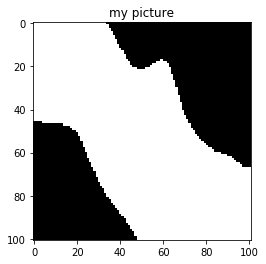

In [6]:
from matplotlib import pyplot as plt
import cv2
%matplotlib inline
img = cv2.imread('../data/train/masks/0a1742c740.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(gray)
plt.title('my picture')
plt.show()

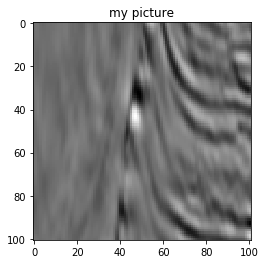

In [7]:
img = cv2.imread('../data/train/images/0ba541766e.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(gray)
plt.title('my picture')
plt.show()

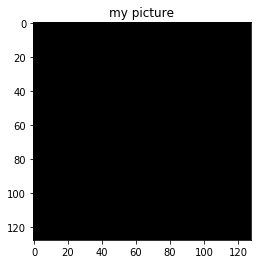

In [8]:
img = cv2.imread('../data/train/masks/575d24d81d.png')
img = cv2.flip( img, 1 )
height, width, _ = img.shape

# Padding in needed for UNet models because they need image size to be divisible by 32 
if height % 32 == 0:
    y_min_pad = 0
    y_max_pad = 0
else:
    y_pad = 32 - height % 32
    y_min_pad = int(y_pad / 2)
    y_max_pad = y_pad - y_min_pad

if width % 32 == 0:
    x_min_pad = 0
    x_max_pad = 0
else:
    x_pad = 32 - width % 32
    x_min_pad = int(x_pad / 2)
    x_max_pad = x_pad - x_min_pad

img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REPLICATE)#cv2.BORDER_REFLECT_101)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(gray)
plt.title('my picture')
plt.show()

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision.transforms.functional as Func
from torch.utils import data
import tqdm
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

class TGSSaltDataset(data.Dataset):
    def __init__(self, root_path, file_list, is_test = False, h_flip=False,crop=False,brightness=False,ratio=0.75):
        self.is_test = is_test
        self.root_path = root_path
        self.file_list = file_list
        self.h_flip = h_flip
        self.crop=crop
        self.crop_ratio = ratio
        self.brightness = brightness
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))
        
        file_id = self.file_list[index]
        
        image_folder = os.path.join(self.root_path, "images")
        image_path = os.path.join(image_folder, file_id + ".png")
        
        mask_folder = os.path.join(self.root_path, "masks")
        mask_path = os.path.join(mask_folder, file_id + ".png")
        
        image = load_image(image_path, h_flip=self.h_flip,crop = self.crop,ratio = self.crop_ratio,brightness=self.brightness)
        
        if self.is_test:
            return (image,)
        else:
            mask = load_image(mask_path, mask = True, h_flip=self.h_flip, crop=self.crop,ratio = self.crop_ratio,brightness=self.brightness)
            return image,mask

In [10]:
# depths_df = pd.read_csv(os.path.join(directory, 'train.csv'))
train_df = pd.read_csv("../data/train.csv", index_col="id", usecols=[0,1])
train_df["masks"] = [cv2.imread("../data/train/masks/{}.png".format(idx),0) / 255 for idx in train_df.index]
train_df["coverage"] = train_df.masks.map(np.sum) / pow(101, 2)
zero_df = train_df[train_df.coverage==0]
min_criteria = train_df[train_df.coverage>0.1]
train_df = pd.concat([zero_df,min_criteria])
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)
train_path = os.path.join(directory, 'train')
file_list = list(train_df.index.values)
file_list_train,file_list_val  = train_test_split(file_list,test_size=0.1,stratify=train_df.coverage_class, random_state=1337)

In [11]:
from torchvision import transforms, datasets
CUDA_LAUNCH_BLOCKING=1
# def save_checkpoint(checkpoint_path, model, optimizer):
#     state = {'state_dict': model.state_dict(),
#              'optimizer' : optimizer.state_dict()}
#     torch.save(state, checkpoint_path)
#     print('model saved to %s' % checkpoint_path)
def save_checkpoint(state, is_best):
    filename='sgd_model/'+save_dir+'/best_loss_ph1.pth.tar'
    """Save checkpoint if a new best is achieved"""
    if is_best:
        print ("=> Saving a new best")
        torch.save(state, filename)  # save checkpoint
    else:
        print ("=> Validation loss did not improve")

def save_checkpoint_acc(state, is_best):
    filename='sgd_model/'+save_dir+'/best_acc_ph1.pth.tar'
    """Save checkpoint if a new best is achieved"""
    if is_best:
        print ("=> Saving a new best")
        torch.save(state, filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")
        
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)
    

# file_list_train,file_list_dev = train_test_split(file_train,test_size=0.1,random_state=2)
dataset = torch.utils.data.ConcatDataset([
     TGSSaltDataset(train_path, file_list_train,h_flip=True),
     TGSSaltDataset(train_path, file_list_train),
    TGSSaltDataset(train_path, file_list_train,h_flip=True,crop=True),
     TGSSaltDataset(train_path, file_list_train,crop=True)
#     TGSSaltDataset(train_path, file_list_train,h_flip=True,brightness= True),
#      TGSSaltDataset(train_path, file_list_train,brightness= True),
#     TGSSaltDataset(train_path, file_list_train,h_flip=True,crop=True,brightness= True),
#      TGSSaltDataset(train_path, file_list_train,crop=True,brightness= True)
])

dataset_val = TGSSaltDataset(train_path, file_list_val)
len(dataset)

12324

In [ ]:
model = get_model()
resume_weights = "sgd_model/"+save_dir+"/best_acc_ph1.pth.tar"
checkpoint = torch.load(resume_weights)
start_epoch = checkpoint['epoch']
best_accuracy = checkpoint['best_accuracy']
model.load_state_dict(checkpoint['state_dict'])
print("=> loaded checkpoint '{}' (trained for {} epochs)".format(resume_weights, checkpoint['epoch']))
# print(model)
#
def cyclic_lr(epoch, init_lr=1e-4, num_epochs_per_cycle=6, cycle_epochs_decay=2, lr_decay_factor=0.5):
    epoch_in_cycle = epoch % num_epochs_per_cycle
    lr = init_lr * (lr_decay_factor ** (epoch_in_cycle // cycle_epochs_decay))
    return lr
# learning_rate = 1e-3
# loss_fn = torch.nn.BCELoss()
def criterion(logit, truth ):
    loss = RobustFocalLoss2d()(logit, truth, type='sigmoid')
    return loss

def metric(logit, truth, threshold=0.5 ):
#     prob = F.sigmoid(logit)
    prob = logit
    dice = accuracy(prob, truth, threshold=threshold, is_average=True)
    return dice
# loss_fn = ()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(),momentum=0.9,lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.01)


epoch=60
best_loss=1.
best_acc = 0.
for e in range(epoch):
    learning_rate = cyclic_lr(e)
    print("learning_rate",learning_rate)
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
#     scheduler.step()
    train_loss = []
    train_acc = []
    for image, mask in tqdm.tqdm(data.DataLoader(dataset, batch_size = 12,shuffle=True, num_workers=6)):
        image = image.type(torch.FloatTensor).cuda()
        y_pred = model(Variable(image))
#         loss = loss_fn(y_pred, mask.to(device))
#         loss = lovasz_hinge(y_pred, Variable(mask.cuda()))
        loss = criterion(y_pred, Variable(mask.cuda()))
        dice  = metric(y_pred, Variable(mask.cuda()))
        
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss.append(loss.item())
        train_acc.append(dice.item())
        
    val_loss = []
    val_acc =[]
    for image, mask in data.DataLoader(dataset_val, batch_size = 8, shuffle = False):
        image = image.cuda()
        y_pred = model(Variable(image))

#         loss = lovasz_hinge(y_pred, Variable(mask.cuda()))
        loss = criterion(y_pred, Variable(mask.cuda()))
        dice  = metric(y_pred, Variable(mask.cuda()))
        val_loss.append(loss.item())
        val_acc.append(dice.item())
    print("Epoch: %d, Train loss: %.3f,  Val loss: %.3f" % (e, np.mean(train_loss), np.mean(val_loss)))
    print("Train acc: %.3f, Val acc: %.3f" %(np.mean(train_acc),np.mean(val_acc)))
    val_loss = np.mean(val_loss)
    is_best = bool(val_loss<best_loss)
    # Get greater Tensor to keep track best acc
    best_loss = min(val_loss,best_loss)
    # Save checkpoint if is a new best
    save_checkpoint({
        'epoch': e + 1,
        'state_dict': model.state_dict(),
        'best_accuracy': best_loss
    }, is_best)
    val_acc = np.mean(val_acc)
    is_best_acc = bool(val_acc>best_acc)
    # Get greater Tensor to keep track best acc
    best_acc = max(val_acc,best_acc)
    # Save checkpoint if is a new best
    save_checkpoint_acc({
        'epoch': e + 1,
        'state_dict': model.state_dict(),
        'best_accuracy': best_acc
    }, is_best_acc)

  0%|          | 0/1027 [00:00<?, ?it/s]

=> loaded checkpoint 'sgd_model/vgg_dil/best_acc_ph1.pth.tar' (trained for 1 epochs)
learning_rate 0.0001


/home/mukesh/miniconda3/envs/tgs_torch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 1027/1027 [11:38<00:00,  1.47it/s]


Epoch: 0, Train loss: 0.140,  Val loss: 0.045
Train acc: 0.929, Val acc: 0.941
=> Saving a new best
=> Saving a new best


  0%|          | 0/1027 [00:00<?, ?it/s]

learning_rate 0.0001


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 1, Train loss: 0.027,  Val loss: 0.072
Train acc: 0.964, Val acc: 0.939
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 5e-05


100%|██████████| 1027/1027 [11:25<00:00,  1.50it/s]


Epoch: 2, Train loss: 0.013,  Val loss: 0.063
Train acc: 0.983, Val acc: 0.952
=> Validation loss did not improve
=> Saving a new best


  0%|          | 0/1027 [00:00<?, ?it/s]

learning_rate 5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 3, Train loss: 0.013,  Val loss: 0.064
Train acc: 0.982, Val acc: 0.940
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 2.5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 4, Train loss: 0.008,  Val loss: 0.119
Train acc: 0.988, Val acc: 0.951
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 2.5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 5, Train loss: 0.008,  Val loss: 0.119
Train acc: 0.989, Val acc: 0.949
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 0.0001


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 6, Train loss: 0.021,  Val loss: 0.068
Train acc: 0.973, Val acc: 0.945
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 0.0001


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 7, Train loss: 0.017,  Val loss: 0.059
Train acc: 0.977, Val acc: 0.950
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 8, Train loss: 0.010,  Val loss: 0.063
Train acc: 0.986, Val acc: 0.948
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 9, Train loss: 0.007,  Val loss: 0.156
Train acc: 0.989, Val acc: 0.949
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 2.5e-05


100%|██████████| 1027/1027 [11:09<00:00,  1.53it/s]


Epoch: 10, Train loss: 0.006,  Val loss: 0.122
Train acc: 0.991, Val acc: 0.953
=> Validation loss did not improve
=> Saving a new best


  0%|          | 0/1027 [00:00<?, ?it/s]

learning_rate 2.5e-05


100%|██████████| 1027/1027 [11:10<00:00,  1.53it/s]


Epoch: 11, Train loss: 0.005,  Val loss: 0.132
Train acc: 0.992, Val acc: 0.953
=> Validation loss did not improve
=> Saving a new best


  0%|          | 0/1027 [00:00<?, ?it/s]

learning_rate 0.0001


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 12, Train loss: 0.013,  Val loss: 0.093
Train acc: 0.983, Val acc: 0.943
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 0.0001


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 13, Train loss: 0.014,  Val loss: 0.114
Train acc: 0.981, Val acc: 0.947
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 14, Train loss: 0.008,  Val loss: 0.122
Train acc: 0.988, Val acc: 0.949
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 15, Train loss: 0.008,  Val loss: 0.118
Train acc: 0.989, Val acc: 0.951
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 2.5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 16, Train loss: 0.005,  Val loss: 0.135
Train acc: 0.992, Val acc: 0.949
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 2.5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 17, Train loss: 0.005,  Val loss: 0.146
Train acc: 0.993, Val acc: 0.953
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 0.0001


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 18, Train loss: 0.019,  Val loss: 0.116
Train acc: 0.976, Val acc: 0.947
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 0.0001


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 19, Train loss: 0.015,  Val loss: 0.077
Train acc: 0.979, Val acc: 0.945
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 20, Train loss: 0.009,  Val loss: 0.080
Train acc: 0.988, Val acc: 0.947
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 21, Train loss: 0.008,  Val loss: 0.157
Train acc: 0.988, Val acc: 0.948
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 2.5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 22, Train loss: 0.005,  Val loss: 0.143
Train acc: 0.992, Val acc: 0.946
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 2.5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 23, Train loss: 0.004,  Val loss: 0.175
Train acc: 0.993, Val acc: 0.949
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 0.0001


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 24, Train loss: 0.009,  Val loss: 0.104
Train acc: 0.989, Val acc: 0.951
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 0.0001


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 25, Train loss: 0.012,  Val loss: 0.150
Train acc: 0.983, Val acc: 0.952
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 26, Train loss: 0.008,  Val loss: 0.150
Train acc: 0.989, Val acc: 0.953
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 27, Train loss: 0.010,  Val loss: 0.100
Train acc: 0.988, Val acc: 0.948
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 2.5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 28, Train loss: 0.005,  Val loss: 0.140
Train acc: 0.993, Val acc: 0.946
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 2.5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 29, Train loss: 0.004,  Val loss: 0.207
Train acc: 0.993, Val acc: 0.948
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 0.0001


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 30, Train loss: 0.007,  Val loss: 0.132
Train acc: 0.990, Val acc: 0.952
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 0.0001


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 31, Train loss: 0.012,  Val loss: 0.112
Train acc: 0.984, Val acc: 0.947
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 32, Train loss: 0.006,  Val loss: 0.096
Train acc: 0.991, Val acc: 0.923
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 33, Train loss: 0.005,  Val loss: 0.157
Train acc: 0.993, Val acc: 0.948
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 2.5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 34, Train loss: 0.004,  Val loss: 0.171
Train acc: 0.994, Val acc: 0.947
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 2.5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 35, Train loss: 0.004,  Val loss: 0.167
Train acc: 0.994, Val acc: 0.952
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 0.0001


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 36, Train loss: 0.014,  Val loss: 0.075
Train acc: 0.983, Val acc: 0.941
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 0.0001


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 37, Train loss: 0.012,  Val loss: 0.162
Train acc: 0.985, Val acc: 0.946
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 38, Train loss: 0.006,  Val loss: 0.150
Train acc: 0.991, Val acc: 0.951
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 39, Train loss: 0.005,  Val loss: 0.193
Train acc: 0.993, Val acc: 0.947
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 2.5e-05


  0%|          | 0/1027 [00:00<?, ?it/s]

Epoch: 40, Train loss: 0.004,  Val loss: 0.188
Train acc: 0.994, Val acc: 0.947
=> Validation loss did not improve
=> Validation Accuracy did not improve
learning_rate 2.5e-05


 56%|█████▌    | 571/1027 [06:29<05:10,  1.47it/s]

In [ ]:
best_acc,best_loss

In [13]:
best_acc,best_loss

(0.9549810221028883, 0.03694632477235309)

In [ ]:
resume_weights = "sgd_model/best_acc_ph1.pth.tar"
checkpoint = torch.load(resume_weights)
start_epoch = checkpoint['epoch']
best_accuracy = checkpoint['best_accuracy']
model.load_state_dict(checkpoint['state_dict'])
print("=> loaded checkpoint '{}' (trained for {} epochs)".format(resume_weights, checkpoint['epoch']))

In [ ]:
import glob

test_path = os.path.join(directory, 'test')
test_file_list = glob.glob(os.path.join(test_path, 'images', '*.png'))
test_file_list = [f.split('/')[-1].split('.')[0] for f in test_file_list]
test_file_list[:3], test_path

In [31]:
#NOrmal Image
print(len(test_file_list))
test_dataset = TGSSaltDataset(test_path, test_file_list, is_test = True)

all_predictions = []
for image in tqdm.tqdm(data.DataLoader(test_dataset, batch_size = 8)):
    image = image[0].type(torch.FloatTensor).cuda()
    y_pred = model(Variable(image)).cpu().data.numpy()
    all_predictions.append(y_pred)
all_predictions_stacked = np.vstack(all_predictions)[:, 0, :, :]

  0%|          | 2/2250 [00:00<03:18, 11.35it/s]

18000


100%|██████████| 2250/2250 [02:43<00:00, 13.75it/s]


In [32]:
#Flipped Image
print(len(test_file_list))
test_dataset = TGSSaltDataset(test_path, test_file_list, is_test = True,h_flip=True)

all_predictions_flip = []
for image in tqdm.tqdm(data.DataLoader(test_dataset, batch_size = 8)):
    image = image[0].type(torch.FloatTensor).cuda()
    y_pred = model(Variable(image)).cpu().data.numpy()
    all_predictions_flip.append(y_pred)
all_predictions_stacked_flip = np.vstack(all_predictions_flip)[:, 0, :, :]

  0%|          | 0/2250 [00:00<?, ?it/s]

18000


100%|██████████| 2250/2250 [02:48<00:00, 13.39it/s]


In [33]:
# #Brightness flip Image
# print(len(test_file_list))
# test_dataset = TGSSaltDataset(test_path, test_file_list, is_test = True,h_flip=True,brightness= True)

# all_predictions_flip_bright = []
# for image in tqdm.tqdm(data.DataLoader(test_dataset, batch_size = 8)):
#     image = image[0].type(torch.FloatTensor).cuda()
#     y_pred = model(Variable(image)).cpu().data.numpy()
#     all_predictions_flip_bright.append(y_pred)
# all_predictions_flip_bright = np.vstack(all_predictions_flip_bright)[:, 0, :, :]

In [34]:
# #Brightness Image
# print(len(test_file_list))
# test_dataset = TGSSaltDataset(test_path, test_file_list, is_test = True,brightness= True)

# all_predictions_bright = []
# for image in tqdm.tqdm(data.DataLoader(test_dataset, batch_size = 8)):
#     image = image[0].type(torch.FloatTensor).cuda()
#     y_pred = model(Variable(image)).cpu().data.numpy()
#     all_predictions_bright.append(y_pred)
# all_predictions_bright = np.vstack(all_predictions_bright)[:, 0, :, :]

In [35]:
print(all_predictions_stacked.shape,all_predictions_stacked_flip.shape)

(18000, 128, 128) (18000, 128, 128)


In [36]:
final_pred=[]
# for pred1, pred2, pred3, pred4 in zip(all_predictions_stacked,all_predictions_stacked_flip,all_predictions_flip_bright,all_predictions_bright):
#     final_pred.append((pred1+np.fliplr(pred2)+np.fliplr(pred3)+pred4)/4)
for pred1, pred2 in zip(all_predictions_stacked,all_predictions_stacked_flip):
    final_pred.append((pred1+np.fliplr(pred2))/2)
final_pred = np.array(final_pred)
print(final_pred.shape)

(18000, 128, 128)


In [37]:
height, width = 101, 101

if height % 32 == 0:
    y_min_pad = 0
    y_max_pad = 0
else:
    y_pad = 32 - height % 32
    y_min_pad = int(y_pad / 2)
    y_max_pad = y_pad - y_min_pad

if width % 32 == 0:
    x_min_pad = 0
    x_max_pad = 0
else:
    x_pad = 32 - width % 32
    x_min_pad = int(x_pad / 2)
    x_max_pad = x_pad - x_min_pad

In [38]:
final_pred = final_pred[:, y_min_pad:128 - y_max_pad, x_min_pad:128 - x_max_pad]
final_pred.shape

(18000, 101, 101)

In [44]:
test_dataset = TGSSaltDataset(test_path, test_file_list, is_test = True)

val_predictions = []
val_masks = []
for image, mask in tqdm.tqdm(data.DataLoader(dataset_val, batch_size = 4)):
    image = Variable(image.type(torch.FloatTensor).cuda())
    y_pred = model(image).cpu().data.numpy()
    val_predictions.append(y_pred)
    val_masks.append(mask)
    
val_predictions_stacked = np.vstack(val_predictions)[:, 0, :, :]

val_masks_stacked = np.vstack(val_masks)[:, 0, :, :]
val_predictions_stacked = val_predictions_stacked[:, y_min_pad:128 - y_max_pad, x_min_pad:128 - x_max_pad]

val_masks_stacked = val_masks_stacked[:, y_min_pad:128 - y_max_pad, x_min_pad:128 - x_max_pad]
val_masks_stacked.shape, val_predictions_stacked.shape


100%|██████████| 86/86 [00:03<00:00, 24.26it/s]


((343, 101, 101), (343, 101, 101))

In [45]:
from sklearn.metrics import jaccard_similarity_score

metric_by_threshold = []
for threshold in np.linspace(0, 1, 11):
    val_binary_prediction = (val_predictions_stacked > threshold).astype(int)
    
    iou_values = []
    for y_mask, p_mask in zip(val_masks_stacked, val_binary_prediction):
        iou = jaccard_similarity_score(y_mask.flatten(), p_mask.flatten())
        iou_values.append(iou)
    iou_values = np.array(iou_values)
    
    accuracies = [
        np.mean(iou_values > iou_threshold)
        for iou_threshold in np.linspace(0.5, 0.95, 10)
    ]
    print('Threshold: %.1f, Metric: %.3f' % (threshold, np.mean(accuracies)))
    metric_by_threshold.append((np.mean(accuracies), threshold))
    
best_metric, best_threshold = max(metric_by_threshold)

Threshold: 0.0, Metric: 0.157
Threshold: 0.1, Metric: 0.472
Threshold: 0.2, Metric: 0.711
Threshold: 0.3, Metric: 0.857
Threshold: 0.4, Metric: 0.901
Threshold: 0.5, Metric: 0.915
Threshold: 0.6, Metric: 0.905
Threshold: 0.7, Metric: 0.881
Threshold: 0.8, Metric: 0.844
Threshold: 0.9, Metric: 0.783
Threshold: 1.0, Metric: 0.583


In [41]:
final_pred.shape

(18000, 101, 101)

In [42]:
threshold = best_threshold
binary_prediction = (final_pred > threshold).astype(int)

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

all_masks = []
for p_mask in list(binary_prediction):
    p_mask = rle_encoding(p_mask)
    all_masks.append(' '.join(map(str, p_mask)))


In [43]:
submit = pd.DataFrame([test_file_list, all_masks]).T
submit.columns = ['id', 'rle_mask']
submit.to_csv('results/submit_unet_img_aug_4.csv', index = False)

# 